In [1]:
import pandas as pd
import json
from utils import flat_json

/sise/bshapira-group/hitter-hazizb/yuval/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def append_col_horizontally(flat_data, col_name, prefix):
    """
    - generate_data flattened horizontally with RES1_, RES2_, ...
    """
    

    # Flatten generate_data horizontally
    for i, entry in enumerate(flat_data.pop(col_name, []), start=1):
        for key, value in entry.items():
            flat_data[f"{prefix}{i}_{key}"] = value

    # Return as a single-row DataFrame
    return flat_data

def take_all_key_with_prefix(data, suffix:str):
    result = []
    for key, value in data.items():
        if key.endswith(suffix):
            result.append(value)
    return result


In [3]:
path_data = "data/asdiv_evaluation_format.json"
with open(path_data, "r") as f:
    check_data = json.load(f)
len(check_data)

2305

In [4]:
prefix = "RES"
suffix = "num_of_think_tokens"
path = "result/deepseek_r1_distill_qwen_7b/asdiv_evaluation_format.json"
with open(path, "r") as f:
    data = json.load(f)
rows_sorted = sorted(data, key=lambda x: int(x["metadata"]["grade"]))
col_name = "generate_data"
len(rows_sorted)

2000

In [5]:
all_rows = []
for i, test_row in enumerate(rows_sorted):
    # if "is_correct_judged" not in test_row:
    #     continue
    flat_data = flat_json(test_row, filter_keys={col_name})
    row = append_col_horizontally(flat_data, col_name, prefix=prefix)
    #print("Flattened single row DataFrame:")
    
    arr_data = take_all_key_with_prefix(row, suffix)
    #print(arr_data)
    mean_value = sum(arr_data) / len(arr_data)
    min_value = min(arr_data)
    max_value = max(arr_data)

    row[f"mean_value_{suffix}"] = mean_value
    row[f"min_value_{suffix}"] = min_value
    row[f"max_value_{suffix}"] = max_value

    # for key, value in row.items():
    #     print(f"{key}: {value}")

    all_rows.append(row)
df = pd.DataFrame(all_rows)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dataset                         2000 non-null   object 
 1   split                           2000 non-null   object 
 2   question_id                     2000 non-null   object 
 3   question                        2000 non-null   object 
 4   answer                          2000 non-null   object 
 5   has_reasoning                   2000 non-null   bool   
 6   reasoning                       0 non-null      object 
 7   grade                           2000 non-null   object 
 8   solution_type                   2000 non-null   object 
 9   formula                         2000 non-null   object 
 10  source                          2000 non-null   object 
 11  subtypes                        2000 non-null   object 
 12  RES1_think                      20

In [6]:
import numpy as np

import matplotlib.pyplot as plt

def plot_column_values(df, column_name, graph_topic, show_trend=True, trend_degree=1):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    x_pos = np.arange(len(df))
    y = df[column_name].astype(float).values

    plt.figure(figsize=(8, 5))
    plt.bar(x_pos, y, alpha=0.7)

    if show_trend and len(df) > trend_degree:
        coeffs = np.polyfit(x_pos, y, trend_degree)
        trend = np.polyval(coeffs, x_pos)
        plt.plot(x_pos, trend, color='red', linewidth=2, label=f"Trend (deg {trend_degree})")

        # R^2
        ss_res = np.sum((y - trend) ** 2)
        ss_tot = np.sum((y - y.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else float("nan")
        plt.annotate(f"R² = {r2:.3f}", xy=(0.98, 0.98), xycoords="axes fraction",
                     ha="right", va="top", fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"))

    plt.title(f"{graph_topic} \n{column_name} values by index")
    plt.xlabel("Index")
    plt.ylabel(column_name)
    plt.xticks(x_pos, df.index.astype(str), rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


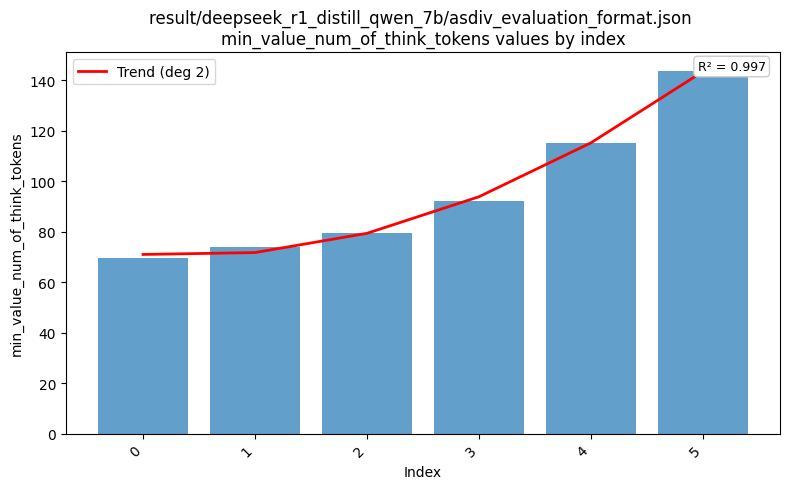

: 

In [ ]:

result = df.groupby("grade", as_index=False)[f"min_value_{suffix}"].mean()
plot_column_values(result, column_name=f"min_value_{suffix}", graph_topic=path, show_trend=True, trend_degree=2)